# The Challenge
***

The sinking of the Titanic is one of the most infamous shipwrecks in history.
On April 15, 1912, during her maiden voyage, the widely considered "unsinkable" RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren't enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: "what sorts of people were more likely to survive?" using passenger data (ie name, age, gender, socio-economic class, etc).

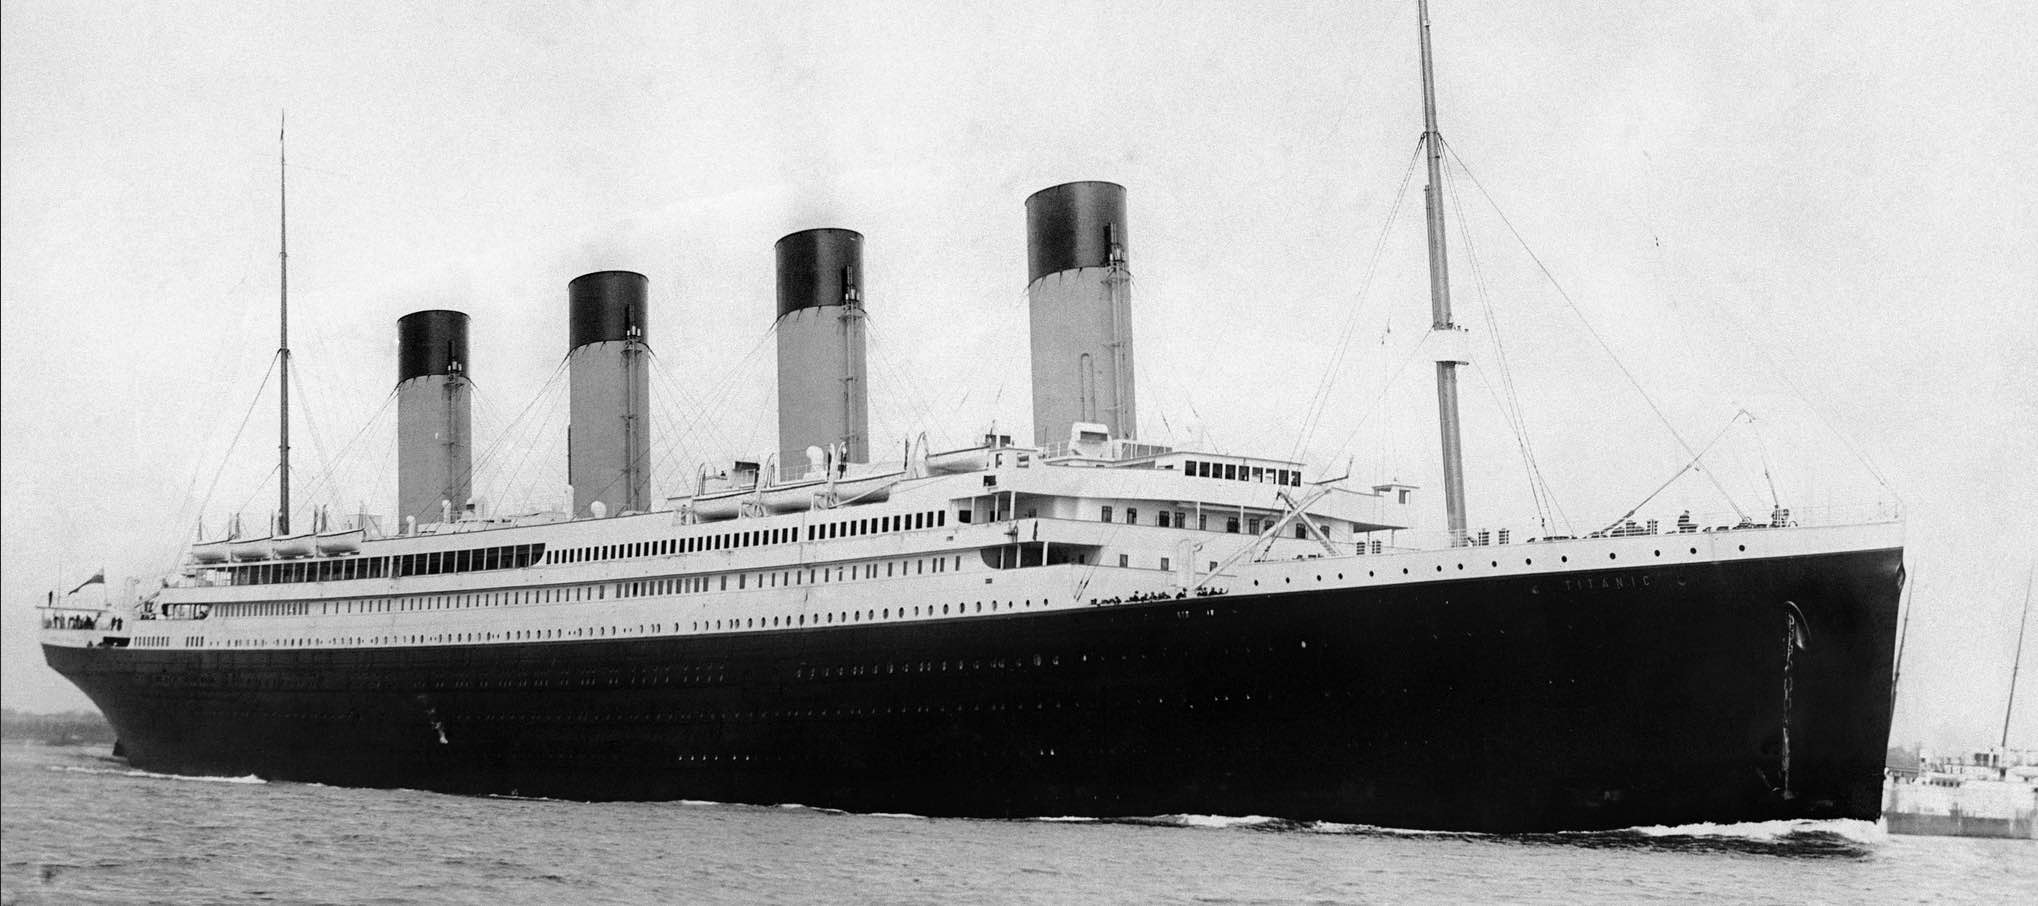

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.model_selection as skm
import sklearn as sk
import missingno as msno
import seaborn as sns
%matplotlib inline

sns.set_theme()

## View data
***

Let's view the data.

In [8]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Variable Notes
- PassengerId: The unique id of the row and it doesn't have any effect on target
- Ticket: The ticket number of the passenger
- Fare: The passenger fare
- Cabin: The cabin number of the passenger
- Embarked: Port of Embarkation 
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton
- Pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- Age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- Sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
- Parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them


In [9]:
def write_prediction(prediction, name):
    PassengerId = np.array(test['PassengerId']).astype(int)
    solution = pd.DataFrame(prediction, PassengerId, columns = ['Survived'])
    solution.to_csv(name, index_label = ['PassengerId'])

## Cleaning the data
***

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We drop the Cabin column as it has too many missing values. Conversely, we will impute missing data for the Age and Fare columns using the MICE algorithm. The algoritm works roughly as follows:

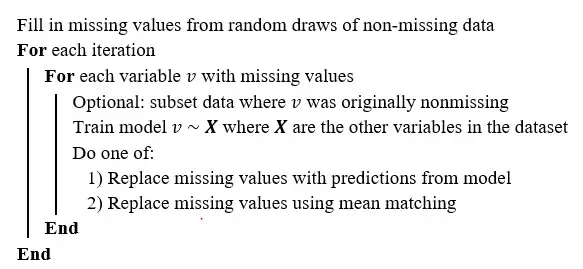

In order to clean the training and test data easily, we create the following function, which has some additional functionality.

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def cleanData(data):

    # Use MICE algorithm to impute Age and Fare Data
    imputer = IterativeImputer(random_state=0, max_iter=20) # Define imputer
    imputer.fit(data[['Age','Fare']]) # impute
    df_imputed = imputer.transform(data[['Age','Fare']])
    data[['Age','Fare']] = df_imputed 

    # Encode Sex column
    data.loc[data['Sex'] == 'male', 'Sex'] = 0
    data.loc[data['Sex'] =='female',  'Sex'] = 1

    # Impute Embarked with majority class
    N = data['Embarked'].isnull().sum()
    data['Embarked'] = data['Embarked'].fillna(N)
    # Encode Embarked column
    data.loc[data["Embarked"] == 'S', 'Embarked'] = 0
    data.loc[data['Embarked'] == 'C', 'Embarked'] = 1
    data.loc[data['Embarked'] == 'Q', 'Embarked'] = 2

    # Drop the Cabin column
    data.drop(columns=['Cabin'],inplace=True)

We now clean the data:

In [6]:
cleanData(train)
cleanData(test)

## Feature Engineering
***
Let's now visualise the distribution of the inputs.

/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


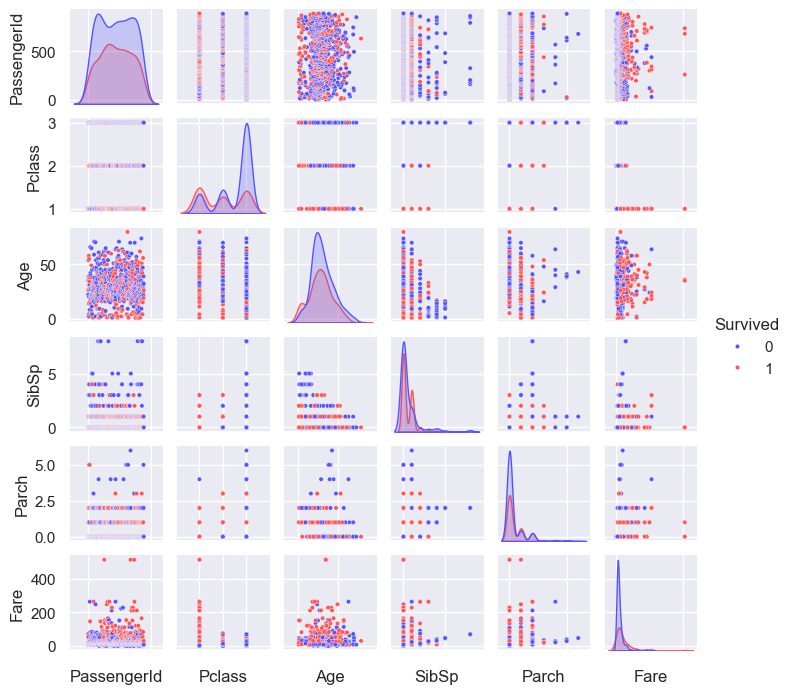

In [10]:
g = sns.pairplot(data=train, hue='Survived', palette = 'seismic',
                 height=1.2,diag_kind = 'kde',diag_kws=dict(fill=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

We generate a new feature *FamilySize* :

In [11]:
all_data=[train,test]
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Impute missing data
***

We check for missing values.

<Axes: >

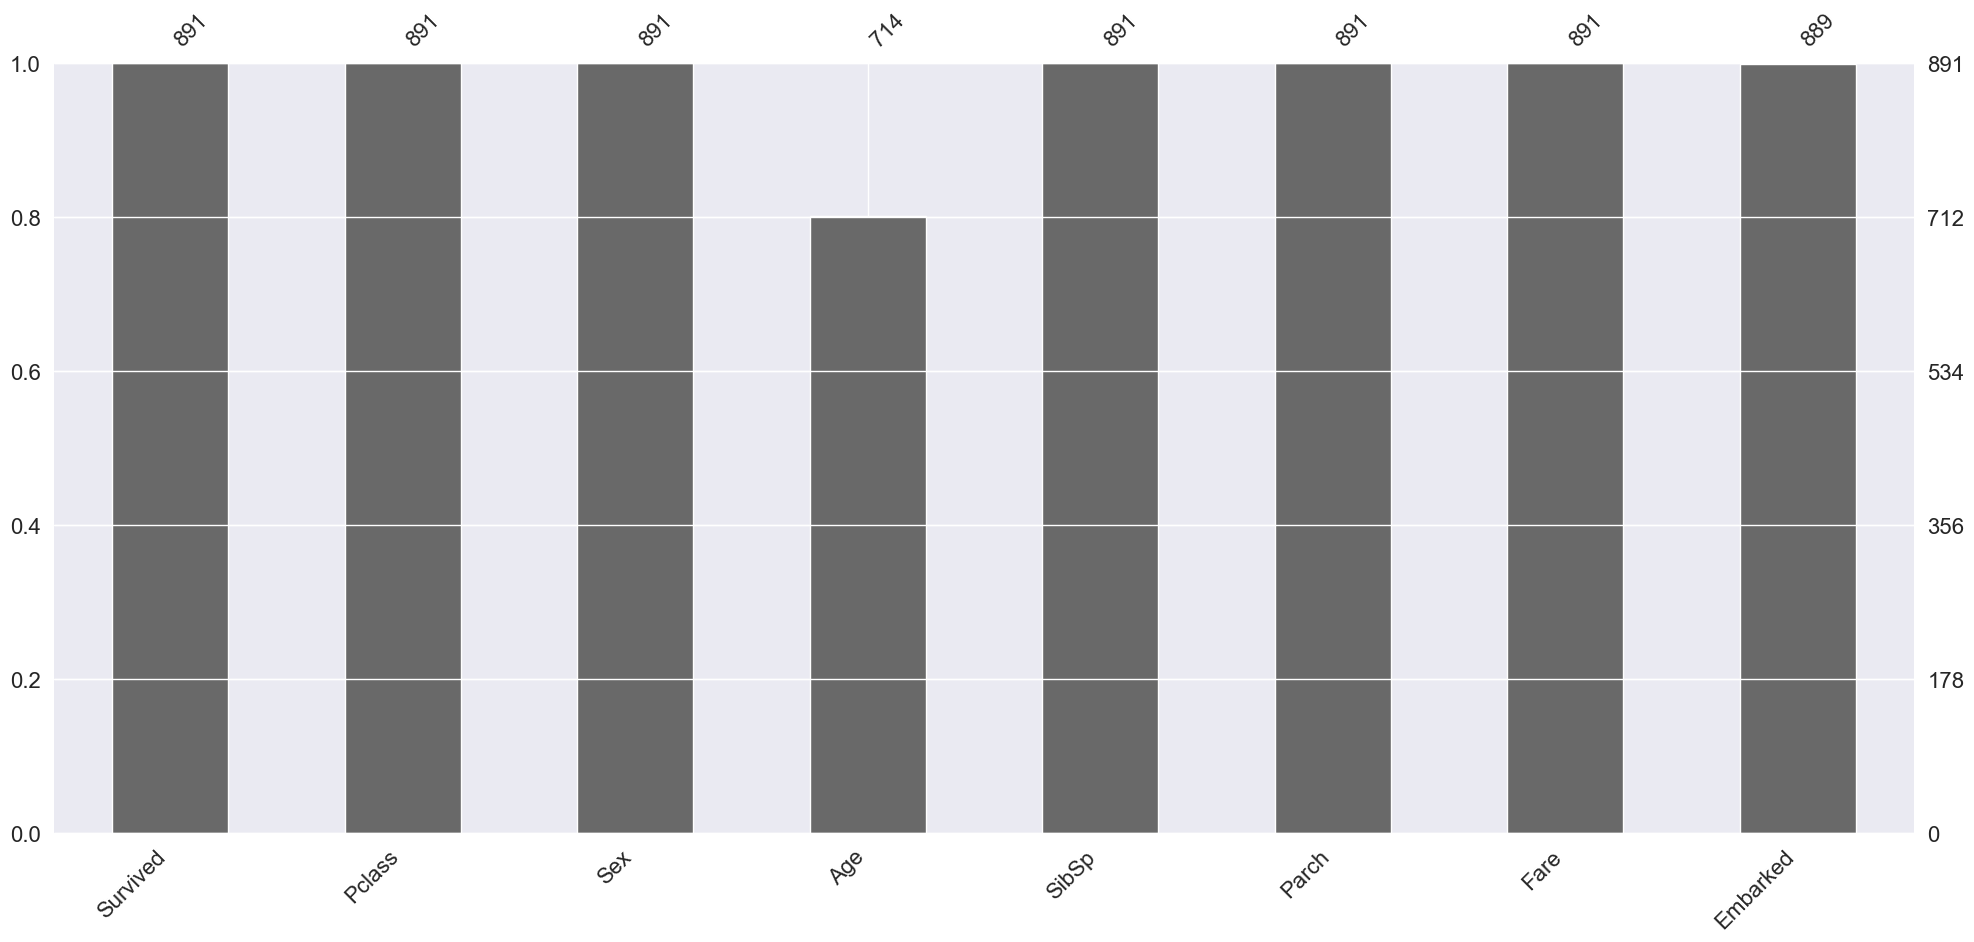

In [50]:
msno.bar(train_data)

Impute 'Embarked' with it's majority class.

In [51]:
N = train_data['Embarked'].isnull().sum()
train_data['Embarked'] = train_data['Embarked'].fillna(N)

We now impute the missing age data using the MICE algorithm. 

The algoritm works roughly as follows:

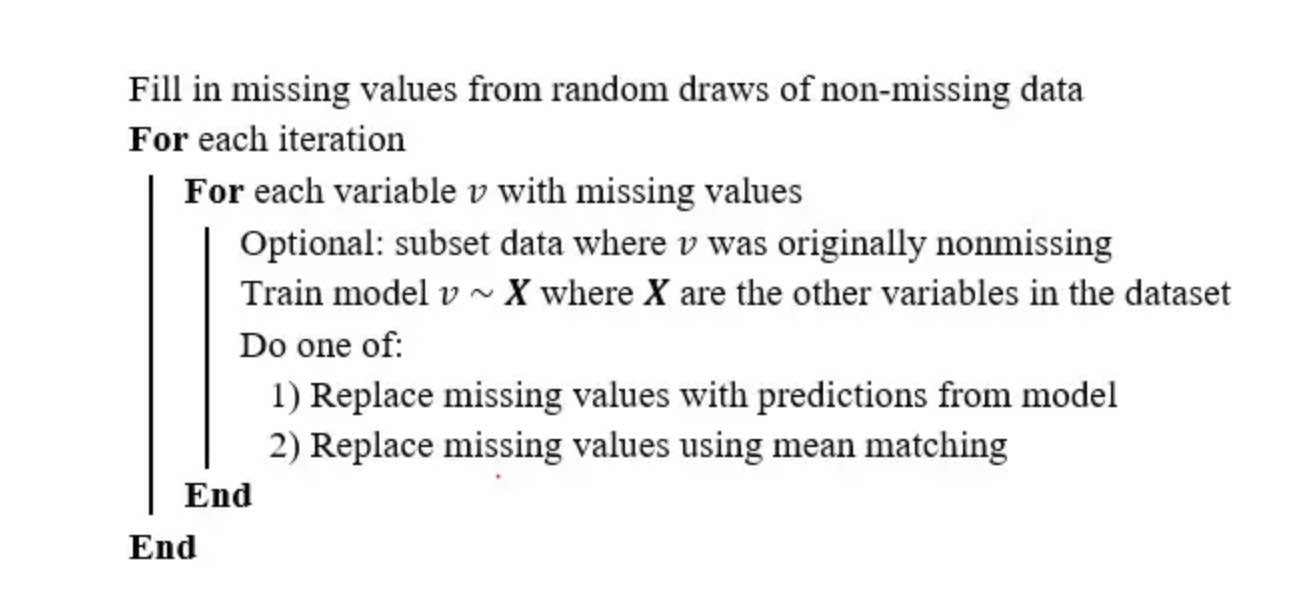

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0, max_iter=20) # Define imputer

imputer.fit(train_data[['Age']]) # impute

IterativeImputer(max_iter=20, random_state=0)

We now replace the missing age data:

In [53]:
df_imputed = imputer.transform(train_data[['Age']])
train_data[['Age']] = df_imputed # Replace the missing data with the imputed data
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [56]:
df_imputed = imputer.transform(test_data[['Age']])
test_data[['Age']] = df_imputed # Replace the missing data with the imputed data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,2
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,2


<Axes: >

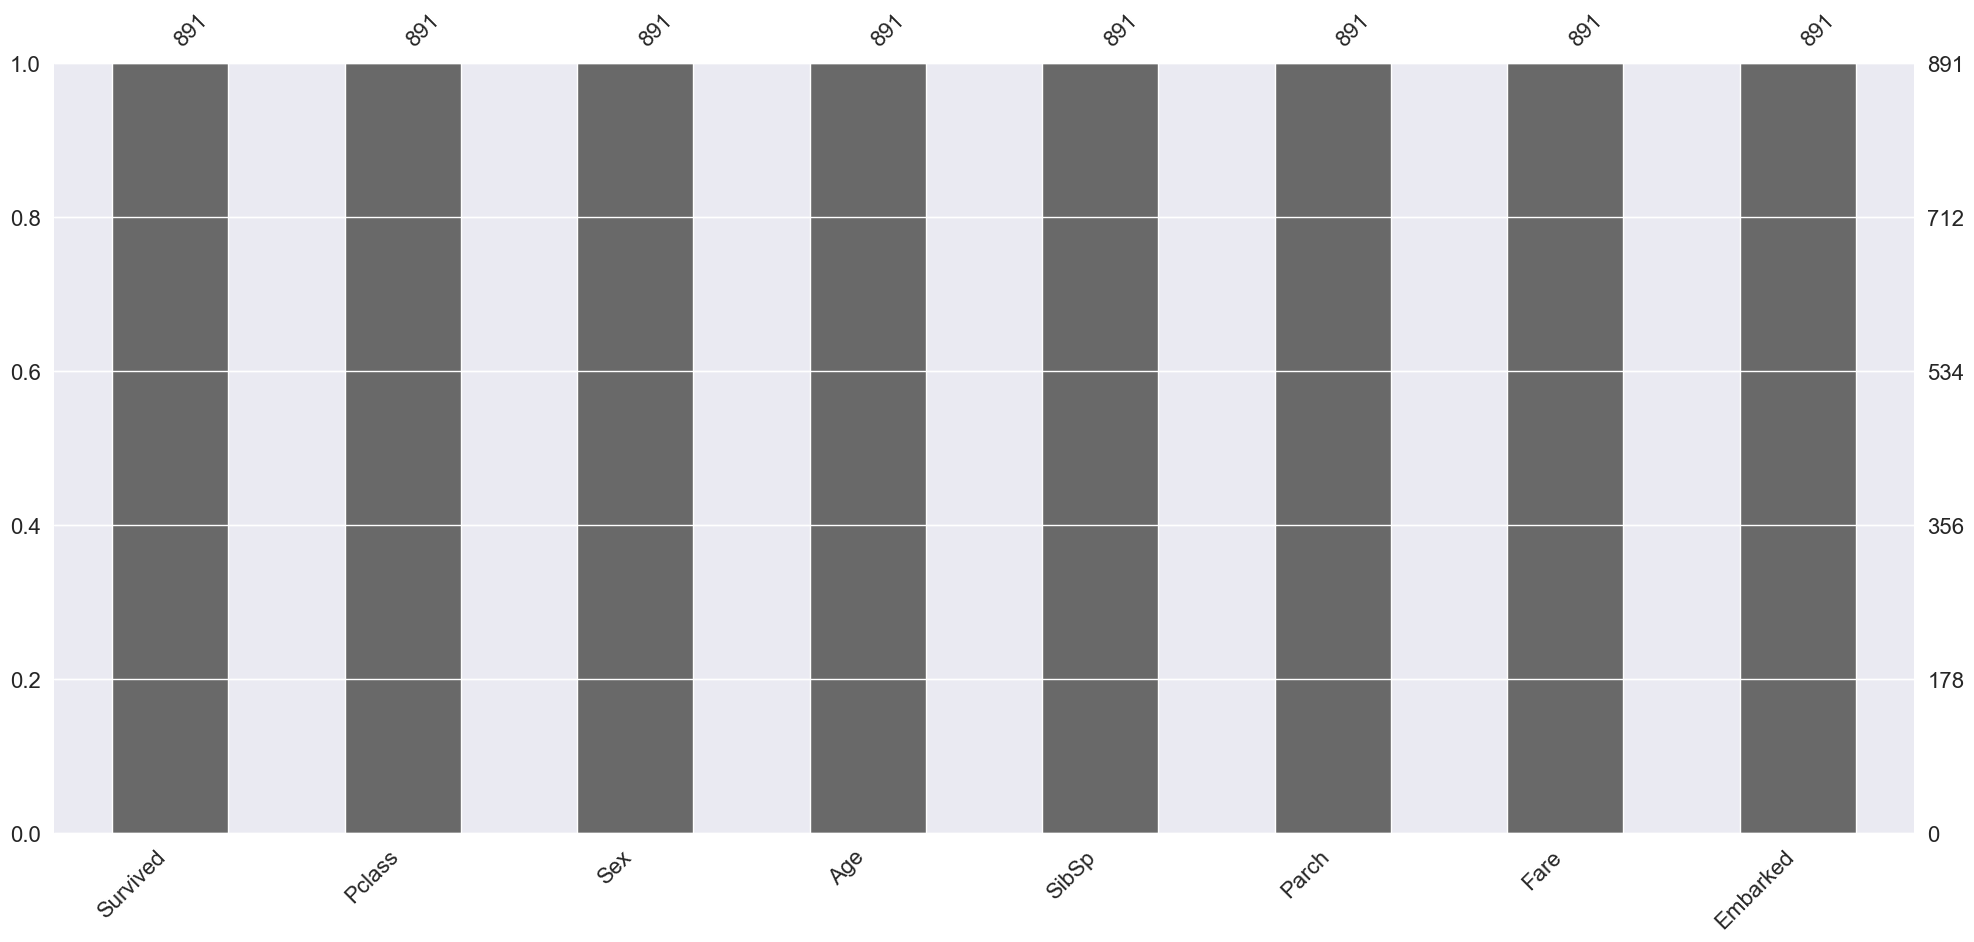

In [54]:
msno.bar(train_data)

In [58]:
train_data.to_csv('data/processedTrain.csv', index=False)
train_data.head()
test_data.to_csv('data/processedTest.csv', index=False)
